In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader, random_split
# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化到[-1, 1]
])

# 加载训练集和测试集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 计算采样数量
total_train_size = len(trainset)
total_test_size = len(testset)
train_sample_size = int(total_train_size * 1)  
test_sample_size = int(total_test_size * 1)    

# 随机分割训练集和测试集
train_subset, _ = random_split(trainset, [train_sample_size, total_train_size - train_sample_size])
test_subset, _ = random_split(testset, [test_sample_size, total_test_size - test_sample_size])

# 创建 DataLoader
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
testloader = DataLoader(test_subset, batch_size=64, shuffle=False)

# 打印数据集信息
print(f"原始训练集图片数量: {total_train_size}")
print(f"采样后的训练集图片数量: {len(train_subset)}")
print(f"原始测试集图片数量: {total_test_size}")
print(f"采样后的测试集图片数量: {len(test_subset)}")

# 打印一个批次的数据形状
for images, labels in trainloader:
    print(f"一个批次的图片形状: {images.shape}") 
    print(f"一个批次的标签形状: {labels.shape}")
    break

for images, labels in testloader:
    print(f"测试集一个批次的图片形状: {images.shape}") 
    print(f"测试集一个批次的标签形状: {labels.shape}")
    break

原始训练集图片数量: 50000
采样后的训练集图片数量: 50000
原始测试集图片数量: 10000
采样后的测试集图片数量: 10000
一个批次的图片形状: torch.Size([64, 3, 32, 32])
一个批次的标签形状: torch.Size([64])
测试集一个批次的图片形状: torch.Size([64, 3, 32, 32])
测试集一个批次的标签形状: torch.Size([64])


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

In [3]:
def extract_sift_features(dataset):
    sift = cv2.SIFT_create()
    features = []
    labels = []
    for img, label in dataset:
        img = (img * 255).numpy().transpose(1, 2, 0).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.mean(axis=0))  # 使用特征的均值作为图像的表示
        else:
            features.append(np.zeros(128))  # 如果没有检测到特征点，用零向量填充
        labels.append(label)
    return np.array(features), np.array(labels)

# 提取训练集和测试集的 SIFT 特征
train_features, train_labels = extract_sift_features(train_subset)
test_features, test_labels = extract_sift_features(test_subset)

In [4]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import label_binarize
# from itertools import cycle
# import time
# # 训练决策树模型
# dt_model = DecisionTreeClassifier()
# print("开始训练决策树模型...")

# # 记录训练开始时间
# start_time = time.time()

# dt_model.fit(train_features, train_labels)

# # 记录训练结束时间
# end_time = time.time()
# train_time = end_time - start_time

# print(f"决策树模型训练完成，耗时 {train_time:.2f} 秒。")

# # 测试决策树模型
# dt_preds = dt_model.predict(test_features)
# dt_accuracy = accuracy_score(test_labels, dt_preds)
# dt_precision = precision_score(test_labels, dt_preds, average='weighted')
# dt_recall = recall_score(test_labels, dt_preds, average='weighted')
# dt_f1 = f1_score(test_labels, dt_preds, average='weighted')

# print(f"决策树 Test Accuracy: {dt_accuracy:.4f}")
# print(f"决策树 Test Precision: {dt_precision:.4f}")
# print(f"决策树 Test Recall: {dt_recall:.4f}")
# print(f"决策树 Test F1 Score: {dt_f1:.4f}")

开始训练决策树模型...
决策树模型训练完成，耗时 9.30 秒。
决策树 Test Accuracy: 0.1332
决策树 Test Precision: 0.1336
决策树 Test Recall: 0.1332
决策树 Test F1 Score: 0.1333


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
import time

# 初始化随机森林分类器
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 开始训练
print("开始训练随机森林模型")
start_time = time.time()
rf_model.fit(train_features, train_labels)
end_time = time.time()
train_time = end_time - start_time
print(f"随机森林模型训练完成，耗时 {train_time:.2f} 秒。")

# 测试模型
rf_preds = rf_model.predict(test_features)
accuracy = accuracy_score(test_labels, rf_preds)

print(f"随机森林 Test Accuracy: {accuracy:.4f}")
print("分类报告：")
print(classification_report(test_labels, rf_preds))

# 测试随机森林模型
rf_preds = rf_model.predict(test_features)
rf_accuracy = accuracy_score(test_labels, rf_preds)
rf_precision = precision_score(test_labels, rf_preds, average='weighted')
rf_recall = recall_score(test_labels, rf_preds, average='weighted')
rf_f1 = f1_score(test_labels, rf_preds, average='weighted')

print(f"随机森林 Test Accuracy: {rf_accuracy:.4f}")
print(f"随机森林 Test Precision: {rf_precision:.4f}")
print(f"随机森林 Test Recall: {rf_recall:.4f}")
print(f"随机森林 Test F1 Score: {rf_f1:.4f}")

开始训练随机森林模型...
随机森林模型训练完成，耗时 11.47 秒。
随机森林 Test Accuracy: 0.1900
分类报告：
              precision    recall  f1-score   support

           0       0.31      0.38      0.34      1000
           1       0.21      0.23      0.22      1000
           2       0.14      0.10      0.12      1000
           3       0.15      0.15      0.15      1000
           4       0.14      0.15      0.15      1000
           5       0.16      0.18      0.17      1000
           6       0.16      0.15      0.15      1000
           7       0.15      0.12      0.14      1000
           8       0.24      0.23      0.24      1000
           9       0.19      0.20      0.20      1000

    accuracy                           0.19     10000
   macro avg       0.19      0.19      0.19     10000
weighted avg       0.19      0.19      0.19     10000

随机森林 Test Accuracy: 0.1900
随机森林 Test Precision: 0.1856
随机森林 Test Recall: 0.1900
随机森林 Test F1 Score: 0.1866


In [7]:
# 定义 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 初始化模型、损失函数和优化器
cnn_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# 训练 CNN 模型
def train_cnn(model, trainloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

train_cnn(cnn_model, trainloader, criterion, optimizer, epochs=10)

# 测试 CNN 模型
cnn_model.eval()
cnn_preds = []
cnn_labels = []
with torch.no_grad():
    for images, labels in testloader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        cnn_preds.extend(predicted.cpu().numpy())
        cnn_labels.extend(labels.cpu().numpy())

cnn_accuracy = accuracy_score(cnn_labels, cnn_preds)
cnn_precision = precision_score(cnn_labels, cnn_preds, average='weighted')
cnn_recall = recall_score(cnn_labels, cnn_preds, average='weighted')
cnn_f1 = f1_score(cnn_labels, cnn_preds, average='weighted')

print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"CNN Test Precision: {cnn_precision:.4f}")
print(f"CNN Test Recall: {cnn_recall:.4f}")
print(f"CNN Test F1 Score: {cnn_f1:.4f}")

Epoch 1/10, Loss: 1.4489, Train Accuracy: 47.09%
Epoch 2/10, Loss: 1.0380, Train Accuracy: 63.18%
Epoch 3/10, Loss: 0.8556, Train Accuracy: 70.18%
Epoch 4/10, Loss: 0.7305, Train Accuracy: 74.52%
Epoch 5/10, Loss: 0.6408, Train Accuracy: 77.61%
Epoch 6/10, Loss: 0.5648, Train Accuracy: 80.11%
Epoch 7/10, Loss: 0.5119, Train Accuracy: 81.79%
Epoch 8/10, Loss: 0.4530, Train Accuracy: 84.03%
Epoch 9/10, Loss: 0.4006, Train Accuracy: 85.68%
Epoch 10/10, Loss: 0.3596, Train Accuracy: 87.17%
CNN Test Accuracy: 0.7742
CNN Test Precision: 0.7812
CNN Test Recall: 0.7742
CNN Test F1 Score: 0.7743


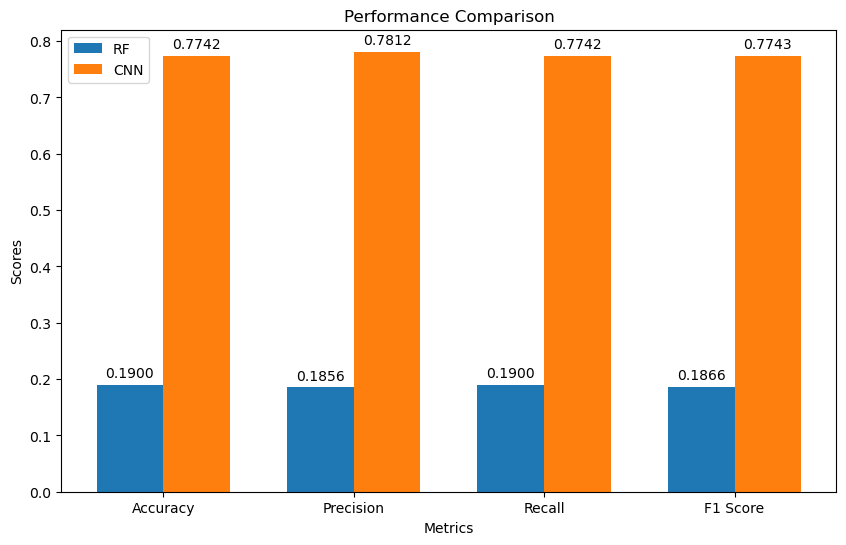

In [20]:
# 性能指标
rf_metrics = [rf_accuracy, rf_precision, rf_recall, rf_f1]
cnn_metrics = [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# 绘制对比图
def plot_performance_comparison(metrics1, metrics2, names1, names2, metrics_names, title):
    x = np.arange(len(metrics_names)) 
    width = 0.35 

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, metrics1, width, label=names1)
    rects2 = ax.bar(x + width/2, metrics2, width, label=names2)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.legend()

    plt.show()

plot_performance_comparison(rf_metrics, cnn_metrics, 'RF', 'CNN', metrics_names, 'Performance Comparison')

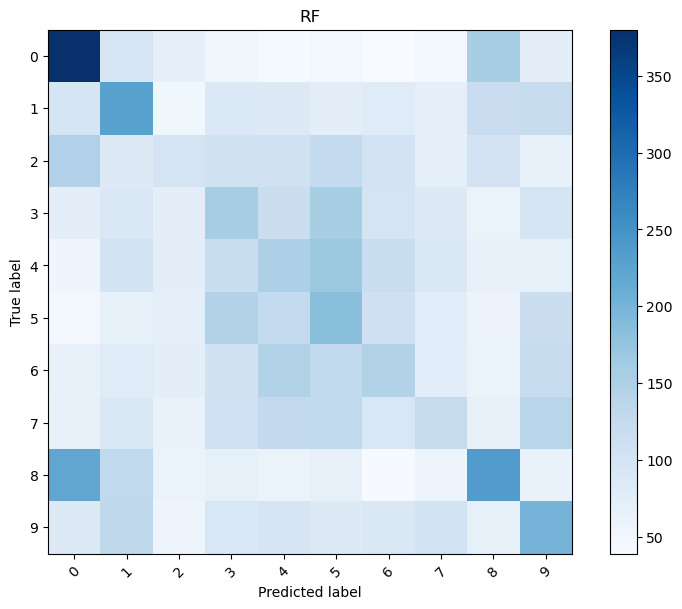

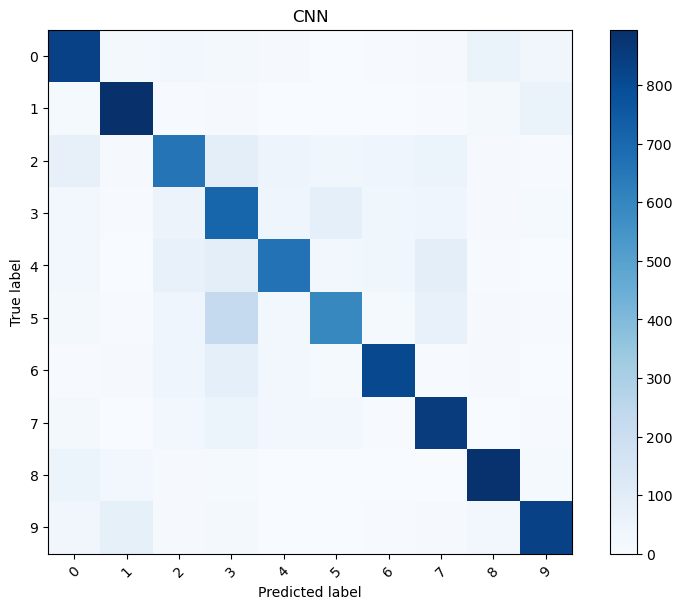

In [16]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_true)))
    plt.xticks(tick_marks, np.unique(y_true), rotation=45)
    plt.yticks(tick_marks, np.unique(y_true))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 绘制混淆矩阵
plot_confusion_matrix(test_labels, rf_preds, "RF")
plot_confusion_matrix(cnn_labels, cnn_preds, "CNN")

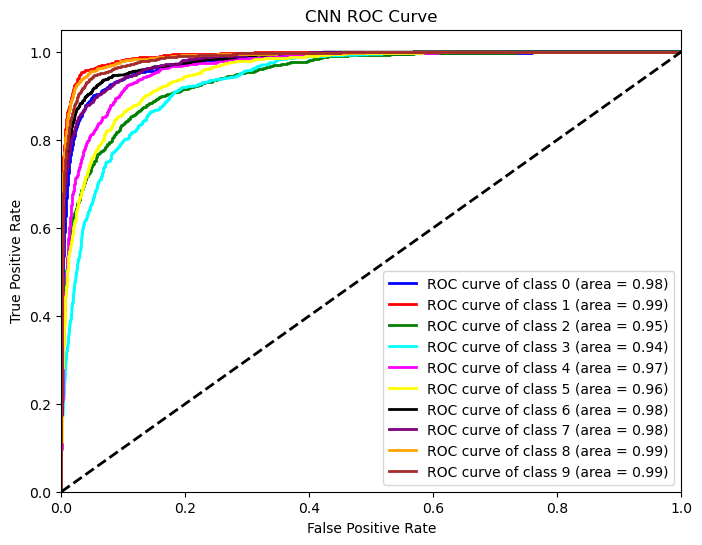

In [14]:
# 绘制 ROC 曲线
def plot_roc_curve(y_true, y_score, title):
    y_true_bin = label_binarize(y_true, classes=np.arange(10))
    n_classes = y_true_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown'])
    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

with torch.no_grad():
    cnn_outputs = cnn_model(torch.cat([images for images, _ in testloader]))
    cnn_probs = torch.softmax(cnn_outputs, dim=1).cpu().numpy()

plot_roc_curve(test_labels, cnn_probs, "CNN ROC Curve")

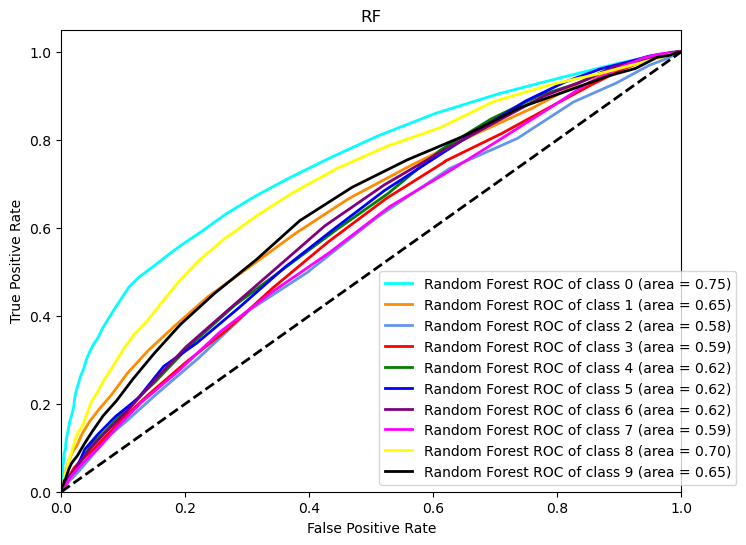

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Binarize the output for multi-class classification
y_test_binarized = label_binarize(test_labels, classes=np.arange(10))
rf_probs = rf_model.predict_proba(test_features)  # 获取随机森林模型对测试集每个类别的预测概率

# Compute ROC curve and ROC area for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

for i in range(10):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_binarized[:, i], rf_probs[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'magenta', 'yellow', 'black'])
for i, color in zip(range(10), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=2,
             label='Random Forest ROC of class {0} (area = {1:0.2f})'.format(i, roc_auc_rf[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF')
plt.legend(loc="lower right", bbox_to_anchor=(1.1, 0))
plt.show()

In [8]:
!pip install opencv-python

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 418.1 kB/s eta 0:00:0000:0100:03

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
